In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

α = .05

from env import get_db_url
import wrangle as wr
import explore as ex

from stats_toolkit import significance_test
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE

from sklearn.preprocessing import PolynomialFeatures

taxvaluedollarcount is what the county assessor is saying the house is worth for tax purposes

# <span style='color:red'> Questions and Key Considerations: </span>
## - Acquire:
- <span style='color:blue'>The taxvaluedollarcnt is a valuation assigned by a tax assessor for the county's tax purposes __not__ a sale amount</span>

## - Wrangle:

## - Explore:

## - Model:
- I feel like I'm struggling to understand whether I'm doing this in the right way.
- <span style = 'color:red'> It may not be worth keeping lat/long. Would it be worth keeping these as a feature, and if so, would it need to be scaled?</span>
- <span style = 'color:red'> I built out my RMSE calculation section __after__ I scaled everything. Is that okay? It appears that others did this before scaling.
    - If I were to do an inverse transform on this, would it have the same effect?</span>

# Acquiring Data:
- Acquiring data for *single family homes* that have transaction dates *during the year of 2017.*

In [2]:
query_df = wr.get_zillow_data()

In [3]:
#query_df['bed_bath_ratio'] = df.bedroomcnt / df.bathroomcnt

In [4]:
#Verifying that the dataset meets the rubric requirement of being 52,441 homes long:
query_df.shape[0] / 52441

1.0

In [5]:
query_df.head()

,bathrooms,bedrooms,value,square_feet,year_built,fips,latitude,longitude,lot_size
0,3.5,4.0,1023282.0,3100.0,1998.0,6059.0,33634931.0,-117869207.0,4506.0
1,1.0,2.0,464000.0,1465.0,1967.0,6111.0,34449266.0,-119281531.0,12647.0
2,2.0,3.0,564778.0,1243.0,1962.0,6059.0,33886168.0,-117823170.0,8432.0
3,3.0,4.0,145143.0,2376.0,1970.0,6037.0,34245180.0,-118240722.0,13038.0
4,3.0,4.0,773303.0,2962.0,1950.0,6037.0,34145202.0,-118179824.0,63000.0


swap these

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

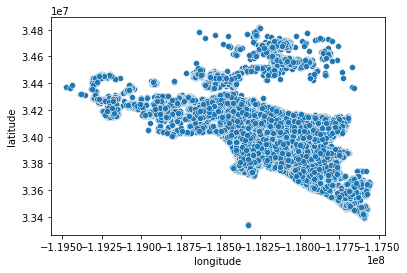

In [6]:
sns.scatterplot(data = query_df, x = query_df.longitude, y = query_df.latitude)

## Wrangling Data:
- General Data Format Cleaning:
    - Converting moving decimal left 6 places on latitude and longitude.
- Assigning county names to each home, based on the fips code one the record:
    - 60370: Los Angeles County
    - 60490: Orange County
    - 61110: Ventura County
- Homes Dropped:
    - 0 bedrooms
    - 0 bathrooms
    - Less than 120 square feet
    - More than 10,000 square feet
    - Home value over \\$1.6 million
    - Records containing null values
- Columns Created:
    - Column displaying the ratios of bedrooms to bathrooms.
- This, paired with the other operations and cleaning carried out in the wrangle script, leave 95.4\% of the data remaining. 
- I feel comfortable with the omission of this data, as I want to ensure that I'm not excluding too large a chunk of my total set, but do want to be sure that I'm focusing my model on homes that comprise the bulk of Zillow's business. Homes priced in the millions are very clearly not the main focus of Zillow's model, so I don't want to skew it's training by including too many of those. See plot below.

In [7]:
#Acquiring CLEANED data, beyond the initial SQL query:
df = wr.wrangle_zillow()

In [8]:
#Verifying how much of the data was cleaned out (less than 5%):
df.shape[0] / query_df.shape[0]

0.9425258862340535

<AxesSubplot:xlabel='lot_size', ylabel='Count'>

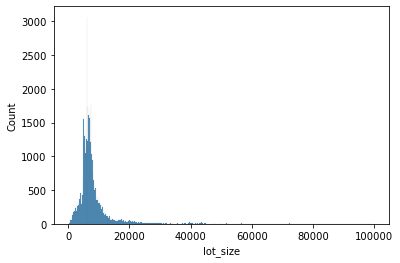

In [9]:
sns.histplot(data = df, x = df.lot_size)

In [10]:
df.lot_size.sort_values(ascending = False).head(100)

42070    99752.0
48223    99411.0
38476    99381.0
18078    99126.0
49753    98881.0
          ...   
40723    75151.0
19789    74922.0
5839     74805.0
16856    74764.0
12545    74664.0
Name: lot_size, Length: 100, dtype: float64

In [11]:
df[df.lot_size > 100_000].shape[0]

0

In [12]:
# splitting the data into train, validate, and test sets before exploration:
train, validate, test = wr.split_zillow_data(df)

# Exploring Data:

## Early Hypotheses:
- More square footage will lead to more value.
- Homes with more land will have more value.
- Location will have a significant impact on value.
- More bedrooms and more bathrooms will lead to more value.
- There will be a relationship between the bath-to-bed ratio and price.
    - Homes with higher bath-to-bed ratios will fetch higher prices.
- Newer houses will fetch more value and be sold less.

## Key Questions Answered:
- Is there a relationship between the county in which a home is built and its value?
- Is there a relationship between the year a home is built and the square footage of a home?

In [13]:
train.head()

,bathrooms,bedrooms,value,square_feet,year_built,latitude,longitude,lot_size,county,bath_bed_ratio
37492,2.0,3,468048.0,3233.0,1950,33.967350,-117.974418,80171.0,Los Angeles County,0.666667
17287,2.0,3,608479.0,1685.0,1956,34.186815,-118.617523,15574.0,Los Angeles County,0.666667
37793,2.0,4,555320.0,1819.0,1958,33.760669,-118.313263,7937.0,Los Angeles County,0.500000
27628,2.5,3,708880.0,2054.0,1986,33.710195,-117.775035,4465.0,Orange County,0.833333
36486,2.0,4,329188.0,1855.0,1987,34.319200,-118.476752,17512.0,Los Angeles County,0.500000


## Visualizing the distribution of homes by price within the train set: 

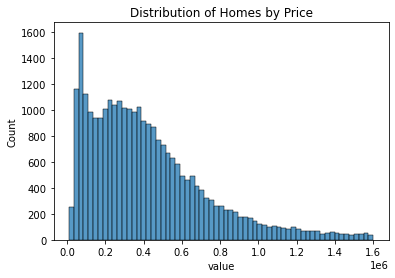

In [14]:
sns.histplot(data = train, x = train.value).set(title = 'Distribution of Homes by Price');

## Visualizing Distribution of Homes by Square Footage:

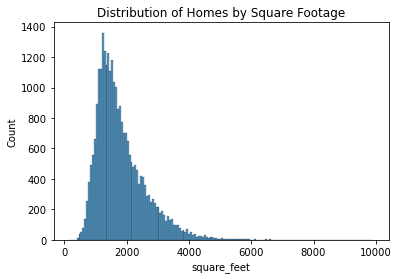

In [15]:
sns.histplot(data = train, x = train.square_feet).set(title = 'Distribution of Homes by Square Footage');

## Visualizing Distribution of Homes by Bedroom Count:

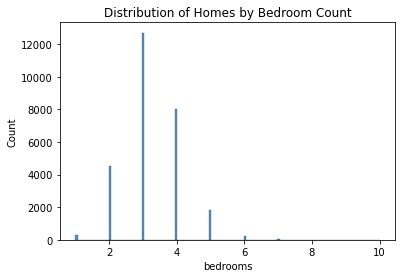

In [16]:
sns.histplot(data = train, x = train.bedrooms).set(title = 'Distribution of Homes by Bedroom Count');

## Visualizing Distribution of Homes by Bathroom Count:

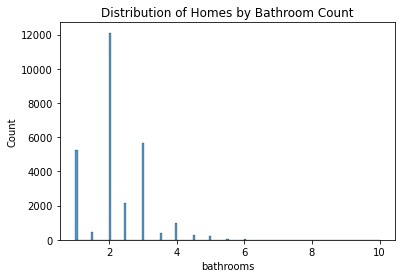

In [17]:
sns.histplot(data = train, x = train.bathrooms).set(title = 'Distribution of Homes by Bathroom Count');

## Visualizing Home Value by Ratio of Bathrooms to Bedrooms:

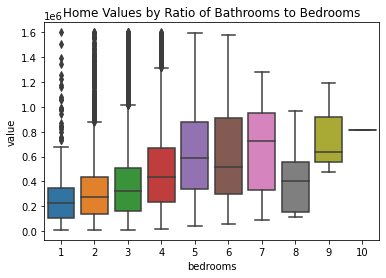

In [18]:
sns.boxplot(data = train, x = train.bedrooms, y = train.value ).set(title = 'Home Values by Ratio of Bathrooms to Bedrooms');

## Visualizing Home Values by County:

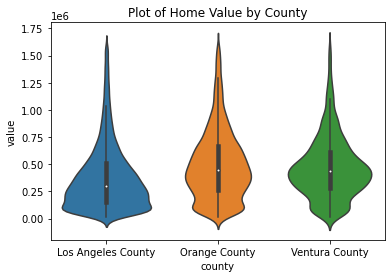

In [19]:
sns.violinplot(data = train, x = train.county, y = train.value ).set(title = 'Plot of Home Value by County');

### Stats: Does County of Residence Have a Meaningful Impact on Value?
- Null Hypothesis: There is no relationship between county and home value.
- Alternative Hypothesis: There is a significant relationship between county and home value.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between home values and county.__

In [20]:
#Creating Separate DataFrames by County:
la_values = train[train.county == 'Los Angeles County'].value
orange_values = train[train.county == 'Orange County'].value
ventura_values = train[train.county == 'Ventura County'].value

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.f_oneway(la_values, orange_values, ventura_values)

#Printing whether the p-value is less than alpha:
significance_test(p), p

Sufficient evidence -> Reject the null hypothesis.


(None, 3.84522782366875e-185)

## Number of Homes for Sale by County:

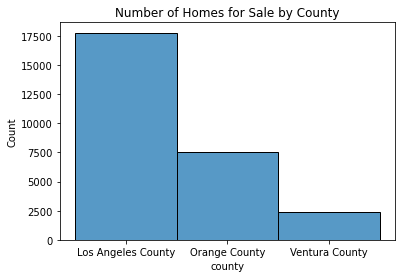

In [21]:
sns.histplot(data = train, x = train.county).set(title = 'Number of Homes for Sale by County');

## Distribution of Homes by Year Built:

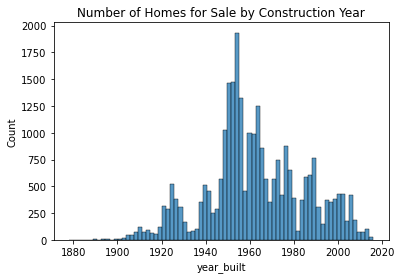

In [22]:
sns.histplot(data = train, x = train.year_built).set(title = 'Number of Homes for Sale by Construction Year');

## The Relationship Between the Year a Home Was Built and the Square Footage:

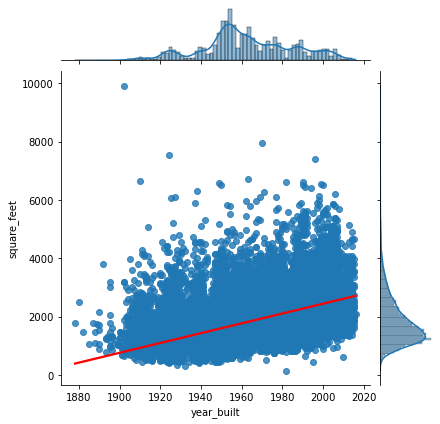

In [23]:
sns.jointplot(x = "year_built", y = "square_feet", data = train, kind = 'reg',
                  joint_kws = {'line_kws':{'color':'red'}});

### Stats: Is there a relationship between the year a home was built and the square footage?
- Null Hypothesis: There is no relationship between the year a home was built and the square footage.
- Alternative Hypothesis: There is a significant relationship between the year a home was built and the square footage.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between construction year and square footage.__ 
    - It appears that as time has progressed, homes are being built larger.

In [24]:
#Running a Pearson's R test to check the correlation between year built and square footage in a home:
corr, p = stats.pearsonr(train.square_feet, train.year_built)
#Running a significance test to determine whether we can reject the null:
corr, significance_test(p)

Sufficient evidence -> Reject the null hypothesis.


(0.4772306749244849, None)

## The Relationship Between the Year a Home Was Built and Its Value:

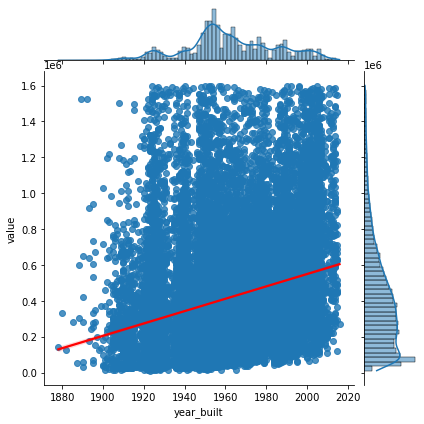

In [25]:
sns.jointplot(x = "year_built", y = "value", data = train, kind = 'reg',
                  joint_kws = {'line_kws':{'color':'red'}});

In [26]:
#Running a Pearson's R test to check the correlation between year built and square footage in a home:
corr, p = stats.pearsonr(train.value, train.year_built)
#Running a significance test to determine whether we can reject the null:
corr, significance_test(p)

Sufficient evidence -> Reject the null hypothesis.


(0.24846102134518736, None)

### Stats: Is there a relationship between the year a home was built and its value?
- Null Hypothesis: There is no relationship between the year a home was built and the value.
- Alternative Hypothesis: There is a significant relationship between the year a home was built and the value.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between construction year and value.__ 
    - It appears that newer homes are valued higher.

# Modeling:

## Prepping Data for Modeling:

### Splitting Train, Validate, Test Into 'X' and 'y' Sets For Modeling: 

In [27]:
#Splitting Train Set:
X_train = train.drop(columns = ['value'])
y_train = train.drop(columns = X_train)

#Splitting Validate Set:
X_validate = validate.drop(columns = ['value'])
y_validate = validate.drop(columns = X_validate)

#Splitting Test Set:
X_test = test.drop(columns = ['value'])
y_test = test.drop(columns = X_test)

### Encoding County Data for Modeling:

In [28]:
X_train = wr.encode_zillow_data(X_train)
X_validate = wr.encode_zillow_data(X_validate)
X_test = wr.encode_zillow_data(X_test)

### Scaling Data:

- don't scale the target (scale everything but the 'y')
- a good way to think about scaling things like years or lat/long:
    - If you're not going to encode these values as though they were categorical variables, then you need scale it like any other continuous variable.
- Future work to develop intuition:
    - You could create 2 versions of the model; one in which things like years are continuous, another in which they are categorical, and then put them through to see which works best. This kind of thing is a great way to develop intuition about different models and what makes them better. 

In [29]:
X_train_scaled, X_validate_scaled, X_test_scaled = wr.scale_zillow_data(X_train, X_validate, X_test)

In [30]:
X_train_scaled

,bathrooms,bedrooms,square_feet,year_built,latitude,longitude,lot_size,bath_bed_ratio,county_Orange County,county_Ventura County
37492,0.111111,0.222222,0.315482,0.521739,33.967350,-117.974418,0.803238,0.063927,0,0
17287,0.111111,0.222222,0.156973,0.565217,34.186815,-118.617523,0.154126,0.063927,0,0
37793,0.111111,0.333333,0.170694,0.579710,33.760669,-118.313263,0.077385,0.041096,0,0
27628,0.166667,0.222222,0.194757,0.782609,33.710195,-117.775035,0.042496,0.086758,1,0
36486,0.111111,0.333333,0.174381,0.789855,34.319200,-118.476752,0.173600,0.041096,0,0
...,...,...,...,...,...,...,...,...,...,...
37442,0.222222,0.333333,0.165677,0.833333,34.686286,-118.243469,0.078932,0.075342,0,0
12763,0.444444,0.333333,0.373336,0.876812,34.245315,-119.086811,0.082550,0.143836,0,1
28191,0.222222,0.333333,0.241143,0.847826,34.425176,-118.436390,0.157422,0.075342,0,0
15886,0.111111,0.222222,0.142535,0.297101,34.097197,-118.359793,0.073496,0.063927,0,0


### Determining the Best k Features:

In [31]:
X_train_scaled.head()

,bathrooms,bedrooms,square_feet,year_built,latitude,longitude,lot_size,bath_bed_ratio,county_Orange County,county_Ventura County
37492,0.111111,0.222222,0.315482,0.521739,33.967350,-117.974418,0.803238,0.063927,0,0
17287,0.111111,0.222222,0.156973,0.565217,34.186815,-118.617523,0.154126,0.063927,0,0
37793,0.111111,0.333333,0.170694,0.579710,33.760669,-118.313263,0.077385,0.041096,0,0
27628,0.166667,0.222222,0.194757,0.782609,33.710195,-117.775035,0.042496,0.086758,1,0
36486,0.111111,0.333333,0.174381,0.789855,34.319200,-118.476752,0.173600,0.041096,0,0


In [32]:
k_features = ex.select_k_features(X_train_scaled, y_train, 10)
k_features

['bathrooms',
 'bedrooms',
 'square_feet',
 'year_built',
 'latitude',
 'longitude',
 'lot_size',
 'bath_bed_ratio',
 'county_Orange County',
 'county_Ventura County']

## Using Recursive Feature Elimination to Find Best Features:
    - Seeing as this dataset is small, I'm okay with using RFE for more accuracy, as
    it's not too intensive.

In [33]:
def rfe_regression(X_train_scaled, y_train, n):
    '''
    Takes in a scaled X_set of a DataFrame, an un-scaled
    y_set of the DataFrame, and 'n' for the number of desired
    features to be selected for modeling. Returns a list of 
    the n best features for the regression model.
    '''
    # Creating the Regression Object:
    lm = LinearRegression()
    # create the rfe object, indicating the ML object (lm) and the number of features I want to use: 
    rfe = RFE(lm, n_features_to_select=10)
    # fit the data using RFE
    rfe.fit(X_train_scaled, y_train)
    # Create the boolean mask that will select best columns:
    feature_mask = rfe.support_
    # Return the list of selected columns: 
    rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    return rfe_feature

In [34]:
rfe_regression = rfe_regression(X_train_scaled, y_train, 10)
rfe_regression

['bathrooms',
 'bedrooms',
 'square_feet',
 'year_built',
 'latitude',
 'longitude',
 'lot_size',
 'bath_bed_ratio',
 'county_Orange County',
 'county_Ventura County']

## Baseline Model:
- It's important to note here that there is no "machine learning" happening with this model; all it is doing is finding the mean (or median) assessed home value and saving that to a new column in the DataFrame.

### Mean Baseline:

In [35]:
#Adding mean baseline value to y_train:
y_train['baseline_mean'] = y_train.value.mean()
#Adding mean baseline value to y_validate:
y_validate['baseline_mean'] = y_validate.value.mean()

### Median Baseline:

In [36]:
#Adding median baseline value to y_train:
y_train['baseline_median'] = y_train.value.median()
#Adding median baseline value to y_validate:
y_validate['baseline_median'] = y_validate.value.median()

### Calculating RMSE for Baselines:

In [37]:
# Creating an empty list for baseline results:
results = []

# Creating a dictionary of baseline mean values:
baseline_mean = {
    'model':'baseline_mean',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['baseline_mean']) ** 0.5,
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['baseline_mean'])** 0.5
}
#Appending baseline mean to results list:
results.append(baseline_mean)

#Creating a DataFrame from the list of result dictionaries:
results = pd.DataFrame(results)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,311821.692922


### Baseline Takeaways:
- The __Mean__ Baseline has a lower RMSE, so I will use that as my baseline for comparison with other models.

## LinearRegression (OLS):

In [38]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lm = LinearRegression(normalize=True)

# Fitting the model to the value in the training set:
lm.fit(X_train_scaled, y_train.value)

# Using OLS to make predictions on training set:
y_train['OLS_pred'] = lm.predict(X_train_scaled)

# Calculating the RMSE for train:
rmse_train = mean_squared_error(y_train.value, y_train.OLS_pred)**(0.5)

# Using OLS to make predictions on validate set:
y_validate['OLS_pred'] = lm.predict(X_validate_scaled)

# Calculating the RMSE for validate:
rmse_validate = mean_squared_error(y_validate.value, y_validate.OLS_pred)**(0.5)

#Creating a dictionary of ols_regression stats:
ols_regression = {
    'model':'ols_regression',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['OLS_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['OLS_pred'])**(0.5)
}

#Adding the ols_regression stats to the empty list:
error.append(ols_regression)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,311821.692922
1,ols_regression,247685.435791,250445.090236


## LassoLars:

In [39]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lars = LassoLars(alpha=1)

# Fitting the model object to the training set:
lars.fit(X_train_scaled, y_train.value)

# Using the LassoLars model to make predictions on the training set:
y_train['lasso_pred'] = lars.predict(X_train_scaled)

# Calculating the RMSE for the training set:
rmse_train = mean_squared_error(y_train.value, y_train.lasso_pred) ** (0.5)

# Using the LassoLars model to make predictions on the validate set:
y_validate['lasso_pred'] = lars.predict(X_validate_scaled)

# Calculating the RMSE for the validate set:
rmse_validate = mean_squared_error(y_validate.value, y_validate.lasso_pred) ** (0.5)

#Creating a dictionary of LassoLars stats:
lasso_lars = {
    'model':'LassoLars',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['lasso_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['lasso_pred'])**(0.5)
}

#print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      #"\nValidation/Out-of-Sample: ", rmse_validate)

#Adding the lasso_lars stats to the empty list:
error.append(lasso_lars)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,311821.692922
1,ols_regression,247685.435791,250445.090236
2,LassoLars,247691.092429,250474.285420


## Tweedie Regressor:

In [40]:
#Creating an empty list for the error calculations:
error = []

# Creating the Tweedie Regression model object:
glm = TweedieRegressor(power=3, alpha=0)

# Fitting the regressor model to the training set:
glm.fit(X_train_scaled, y_train.value)

# Using Tweedie Regressor to make predictions on training set:
y_train['tweedie_pred'] = glm.predict(X_train)

# Calculating RMSE for training set:
rmse_train = mean_squared_error(y_train.value, y_train.tweedie_pred) ** (0.5)

# Using Tweedie Regressor to make predictions on validate set:
y_validate['tweedie_pred'] = glm.predict(X_validate)

# Calculating RMSE for validate set:
rmse_validate = mean_squared_error(y_validate.value, y_validate.tweedie_pred) ** (0.5)

#Creating a dictionary of Tweedie Regressor stats:
tweedie_regressor = {
    'model':'tweedie_regressor',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['tweedie_pred']) ** (0.5),
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['tweedie_pred']) ** (0.5)
}

#Adding the tweedie_regressor stats to the empty list:
error.append(tweedie_regressor)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,311821.692922
1,ols_regression,247685.435791,250445.090236
2,LassoLars,247691.092429,250474.285420
3,tweedie_regressor,311363.354731,311846.896184


### Tweedie Takeaways:
- The distribution of this data seems to most closely resemble an inverse gaussian distribution, so the power was set to 3. 
- The tweedie regressor basically appears to be nearly identical to baseline. 

## Polynomial Regression:

### Polynomial Features:

In [41]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test_scaled)

### Linear Regression with Polynomial Features:

In [42]:
#Creating an empty list for the error calculations:
error = []

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.value)

# predict train
y_train['poly_pred'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.poly_pred) ** 0.5

# predict validate
y_validate['poly_pred'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.poly_pred) ** 0.5

#Creating a dictionary of Tweedie Regressor stats:
polynomial_regressor = {
    'model':'poly_regressor',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['poly_pred']) ** (0.5),
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['poly_pred']) ** (0.5)
}

#Adding the tweedie_regressor stats to the empty list:
error.append(polynomial_regressor)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

#print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
     # "\nValidation/Out-of-Sample: ", rmse_validate)

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,3.118217e+05
1,ols_regression,247685.435791,2.504451e+05
2,LassoLars,247691.092429,2.504743e+05
3,tweedie_regressor,311363.354731,3.118469e+05
4,poly_regressor,239377.101324,4.922462e+18


### Poynomial Regression Takeaways:
- The RMSE on the training set matches that of the OLS linear regression, but the RMSE on the validate set is orders of magnitude higher. 
    - This means that the model is severely overfit to the training set and therefore not generalizable. 

## Overall Modeling Takeaways:
- It appears that of the 4 non-baseline models, it appears that the OLS regression beats the baseline by the most.
- It appears that my OLS model beat the baseline by ~19.8% on the validate set.

In [43]:
ols_performance = (results.RMSE_validate[0] - results.RMSE_validate[1]) / results.RMSE_validate[0]

In [44]:
ols_performance

0.19683236952230299

## Testing Model Performance on the Test Set:

### Generating OLS Regression Prediction for Test and Creating RMSE_test Column:

In [45]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lm = LinearRegression(normalize=True)

# Fitting the model to the values in the training set:
lm.fit(X_train_scaled, y_train.value)

# Using OLS to make predictions on training set:
y_train['OLS_pred'] = lm.predict(X_train_scaled)

# Calculating the RMSE for train:
rmse_train = mean_squared_error(y_train.value, y_train.OLS_pred)**(0.5)

# Using OLS to make predictions on test set:
y_test['OLS_pred'] = lm.predict(X_test_scaled)

# Calculating the RMSE for test:
rmse_validate = mean_squared_error(y_test.value, y_test.OLS_pred)**(0.5)

#Creating a dictionary of ols_regression stats:
ols_regression = {
    'model':'ols_regression',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['OLS_pred'])**(0.5),
    'RMSE_test': mean_squared_error(y_test['value'], y_test['OLS_pred'])**(0.5)
}

#Adding the ols_regression stats to the empty list:
error.append(ols_regression)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate,RMSE_test
0,baseline_mean,311363.354731,3.118217e+05,NaN
1,ols_regression,247685.435791,2.504451e+05,NaN
2,LassoLars,247691.092429,2.504743e+05,NaN
3,tweedie_regressor,311363.354731,3.118469e+05,NaN
4,poly_regressor,239377.101324,4.922462e+18,NaN
5,ols_regression,247685.435791,NaN,250050.139269


### Generating Baseline Model Prediction for Test Now That RMSE_test Column Exists:
- It appears that the model beats the baseline by ~19.44% on the test set.

In [46]:
results['RMSE_test'][0] = mean_squared_error(y_validate['value'], y_validate['baseline_mean'])** 0.5
results

,model,RMSE_train,RMSE_validate,RMSE_test
0,baseline_mean,311363.354731,3.118217e+05,311821.692922
1,ols_regression,247685.435791,2.504451e+05,NaN
2,LassoLars,247691.092429,2.504743e+05,NaN
3,tweedie_regressor,311363.354731,3.118469e+05,NaN
4,poly_regressor,239377.101324,4.922462e+18,NaN
5,ols_regression,247685.435791,NaN,250050.139269


In [47]:
ols_test_performance = (results.RMSE_test[0] - results.RMSE_test[5]) / results.RMSE_test[0]
print(f"The model beats the baseline by {round((ols_test_performance * 100),2)}%.")

The model beats the baseline by 19.81%.
